## 1. Setup & Import Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
import sys

# Configure
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Add src to path - use absolute path for reliability
NOTEBOOK_DIR = Path(os.path.abspath('')).resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
SRC_DIR = PROJECT_ROOT / 'src'
sys.path.insert(0, str(SRC_DIR))

print(f"Project root: {PROJECT_ROOT}")
print(f"Source dir: {SRC_DIR}")
print(f"Source dir exists: {SRC_DIR.exists()}")

# Import custom modules
from models import (
    # Training functions
    train_logistic_regression,
    train_decision_tree,
    train_random_forest,
    train_xgboost,
    train_lightgbm,
    train_all_models,
    
    # Tuning
    tune_hyperparameters,
    cross_validate_model,
    
    # Prediction
    predict,
    predict_proba,
    
    # Model I/O
    save_model,
    load_model,
    
    # Feature importance
    get_feature_importance,
    
    # Availability flags
    XGBOOST_AVAILABLE,
    LIGHTGBM_AVAILABLE
)

from evaluation import (
    # Metrics
    calculate_metrics,
    get_classification_report,
    
    # Plots
    plot_confusion_matrix,
    plot_roc_curve,
    plot_roc_curves_comparison,
    plot_pr_curve,
    plot_pr_curves_comparison,
    plot_feature_importance,
    
    # Model comparison
    compare_models,
    plot_model_comparison,
    
    # Threshold
    find_optimal_threshold,
    plot_threshold_analysis,
    
    # Pipeline
    evaluate_model
)

print("\n✅ Libraries imported successfully!")
print(f"   XGBoost available: {XGBOOST_AVAILABLE}")
print(f"   LightGBM available: {LIGHTGBM_AVAILABLE}")

Project root: C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining
Source dir: C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\src
Source dir exists: True



✅ Libraries imported successfully!
   XGBoost available: True
   LightGBM available: True


## 2. Load Processed Data

In [2]:
# Paths
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'
TABLES_DIR = OUTPUT_DIR / 'tables'
MODELS_DIR = OUTPUT_DIR / 'models'

# Create output directories if not exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("📂 Loading processed data...")

# Load resampled training data (SMOTE applied)
X_train = pd.read_csv(DATA_PROCESSED / 'X_train_resampled.csv')
y_train = pd.read_csv(DATA_PROCESSED / 'y_train_resampled.csv').squeeze()

# Load test data (original, not resampled)
X_test = pd.read_csv(DATA_PROCESSED / 'X_test_encoded.csv')
y_test = pd.read_csv(DATA_PROCESSED / 'y_test.csv').squeeze()

print(f"\n📊 Training data (SMOTE resampled):")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   Class distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 Test data:")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_test shape: {y_test.shape}")
print(f"   Class distribution: {y_test.value_counts().to_dict()}")

📂 Loading processed data...



📊 Training data (SMOTE resampled):
   X_train shape: (120266, 40)
   y_train shape: (120266,)
   Class distribution: {0: 60133, 1: 60133}

📊 Test data:
   X_test shape: (23878, 286)
   y_test shape: (23878,)
   Class distribution: {0: 15033, 1: 8845}


In [3]:
# Check column alignment between train and test
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

if train_cols == test_cols:
    print("✅ Train and Test columns are aligned!")
else:
    print("⚠️ Column mismatch detected!")
    print(f"   In train but not test: {train_cols - test_cols}")
    print(f"   In test but not train: {test_cols - train_cols}")
    
    # Align columns
    common_cols = list(train_cols & test_cols)
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    print(f"\n✅ Aligned to {len(common_cols)} common columns")

# Feature names for later use
feature_names = list(X_train.columns)
print(f"\n📋 Number of features: {len(feature_names)}")

⚠️ Column mismatch detected!
   In train but not test: set()
   In test but not train: {'country_FRO', 'deposit_type_Refundable', 'country_PAK', 'country_KAZ', 'country_VEN', 'country_MDV', 'country_ISL', 'country_COL', 'country_grouped_BRA', 'lead_time_category_30-90ngay', 'country_AIA', 'arrival_season_Winter', 'country_ROU', 'country_grouped_NLD', 'country_TUR', 'hotel_Resort Hotel', 'country_JOR', 'country_SAU', 'country_DNK', 'country_OMN', 'lead_time_category_180-365ngay', 'country_grouped_ITA', 'country_IRL', 'country_BHS', 'country_EST', 'market_segment_Undefined', 'reserved_room_type_L', 'country_SRB', 'country_IRQ', 'assigned_room_type_H', 'reserved_room_type_F', 'country_DJI', 'lead_time_category_7-30ngay', 'country_CHN', 'country_CUB', 'country_KOR', 'country_ASM', 'country_VNM', 'country_ZMB', 'arrival_date_month_January', 'country_BFA', 'country_KEN', 'assigned_room_type_F', 'country_MRT', 'country_SGP', 'country_NIC', 'distribution_channel_Undefined', 'country_PER', 'cus

In [4]:
# Quick look at data
X_train.head()

,arrival_date_day_of_month,arrival_day_of_week,babies,deposit_required,stays_in_week_nights,total_of_special_requests,lead_time,total_revenue,has_canceled_before,booking_changes,...,days_in_waiting_list,requires_parking,total_nights,is_family,arrival_date_year,previous_cancellations,previous_bookings_not_canceled,revenue_per_guest,arrival_date_week_number,is_direct_booking
0,7,1,0,0,2,0,20,196.0,0,0,...,0,0,2,0,2017,0,0,98.0,6,0
1,9,2,0,0,3,0,8,300.0,0,0,...,0,0,3,0,2016,0,0,150.0,11,0
2,6,3,0,1,3,0,93,285.0,0,0,...,0,0,3,0,2017,0,0,142.5,14,0
3,23,2,0,0,6,0,90,540.0,0,0,...,0,0,10,0,2015,0,0,270.0,39,0
4,9,2,0,0,1,0,8,80.0,0,0,...,0,0,1,0,2017,0,0,40.0,32,0


## 3. Verify No Data Leakage

⚠️ **CRITICAL**: Ensure we don't use columns that contain information about the outcome:
- `reservation_status` (contains 'Canceled' directly)
- `reservation_status_date`

In [5]:
# Check for potential leakage columns
leakage_cols = ['reservation_status', 'reservation_status_date', 'is_canceled']

found_leakage = [col for col in leakage_cols if col in X_train.columns]

if found_leakage:
    print(f"🚨 LEAKAGE DETECTED! Found columns: {found_leakage}")
    print("   These columns should NOT be in training features!")
else:
    print("✅ No data leakage detected!")
    print(f"   Checked for: {leakage_cols}")
    print("   None found in training features.")

✅ No data leakage detected!
   Checked for: ['reservation_status', 'reservation_status_date', 'is_canceled']
   None found in training features.


---

# PART A: BASELINE MODELS

---

## 4. Logistic Regression (Baseline 1)

In [6]:
# Train Logistic Regression
model_lr = train_logistic_regression(
    X_train, y_train,
    C=1.0,
    class_weight='balanced',
    verbose=True
)

TRAINING LOGISTIC REGRESSION
Training samples: 120,266
Features: 40
C (regularization): 1.0
Class weight: balanced


Training accuracy: 0.7895


In [7]:
# Evaluate on test set
y_pred_lr = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

metrics_lr = calculate_metrics(y_test, y_pred_lr, y_proba_lr, verbose=True)


CLASSIFICATION METRICS
Accuracy:    0.7645
Precision:   0.6777
Recall:      0.6946
F1 Score:    0.6861
Specificity: 0.8056
ROC-AUC:     0.8391
PR-AUC:      0.8018


✅ Saved confusion matrix to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\cm_logistic_regression.png


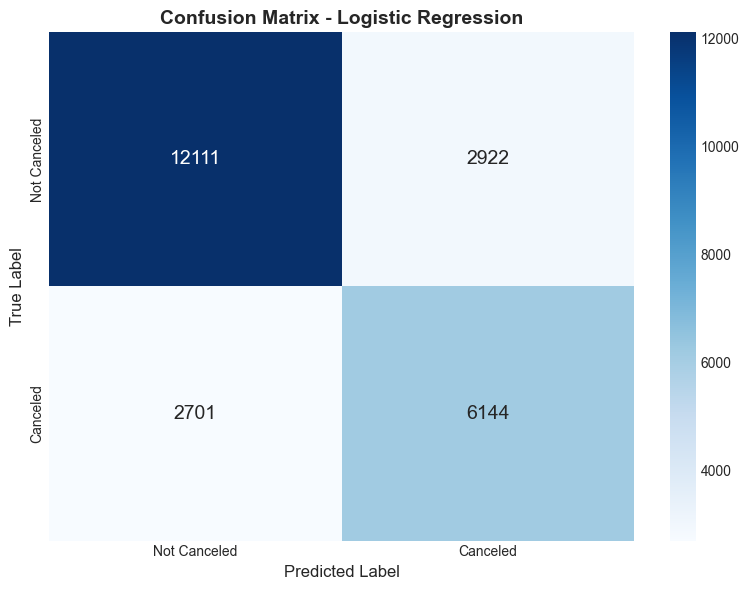

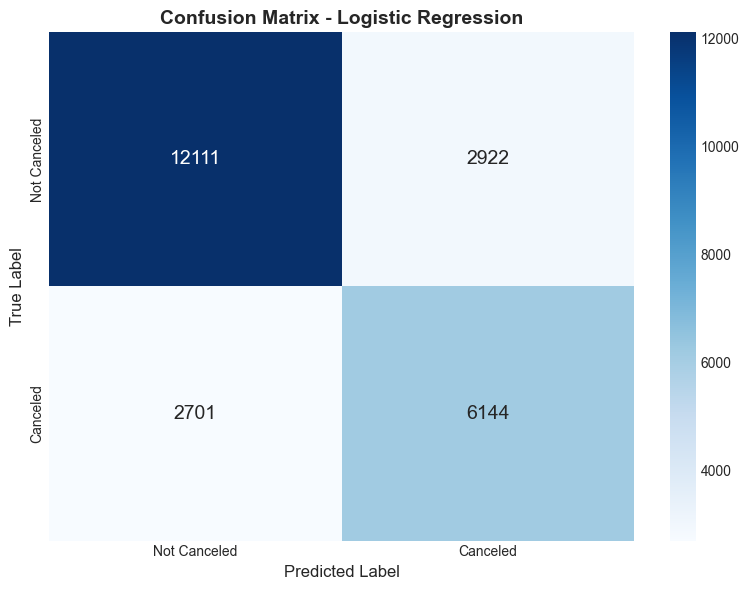

In [8]:
# Confusion Matrix
plot_confusion_matrix(
    y_test, y_pred_lr,
    title='Confusion Matrix - Logistic Regression',
    save_path=str(FIGURES_DIR / 'cm_logistic_regression.png'),
    show=True
)

## 5. Decision Tree (Baseline 2)

In [9]:
# Train Decision Tree
model_dt = train_decision_tree(
    X_train, y_train,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    verbose=True
)

TRAINING DECISION TREE
Training samples: 120,266
Features: 40
Max depth: 10
Min samples split: 20
Class weight: balanced


Training accuracy: 0.8110
Tree depth: 10
Number of leaves: 157


In [10]:
# Evaluate on test set
y_pred_dt = model_dt.predict(X_test)
y_proba_dt = model_dt.predict_proba(X_test)[:, 1]

metrics_dt = calculate_metrics(y_test, y_pred_dt, y_proba_dt, verbose=True)


CLASSIFICATION METRICS
Accuracy:    0.8098
Precision:   0.7794
Recall:      0.6786
F1 Score:    0.7255
Specificity: 0.8870
ROC-AUC:     0.8773
PR-AUC:      0.8283


✅ Saved confusion matrix to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\cm_decision_tree.png


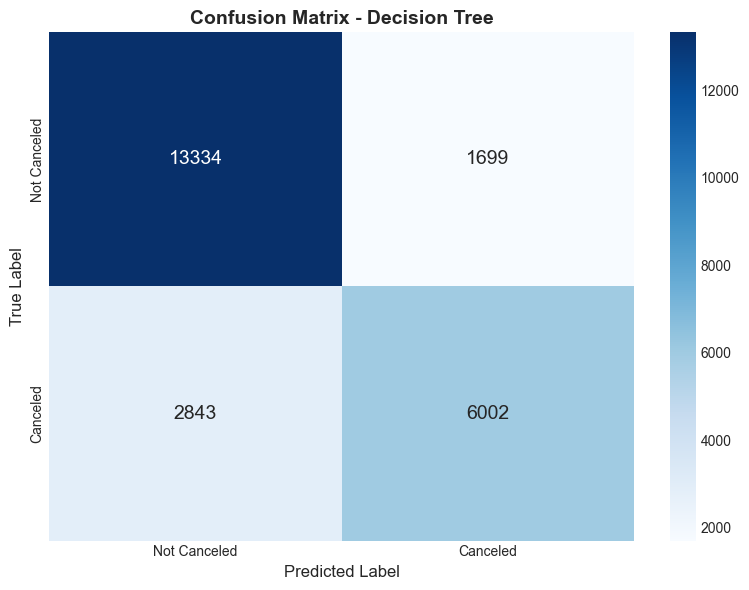

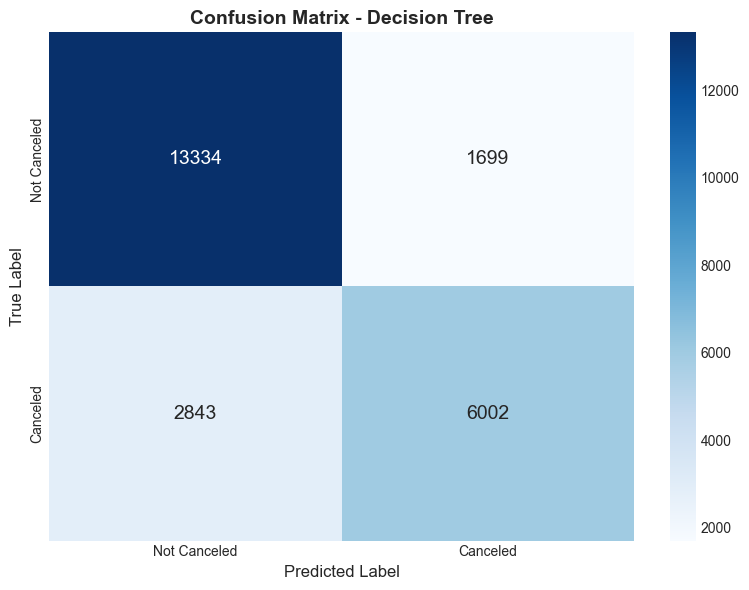

In [11]:
# Confusion Matrix
plot_confusion_matrix(
    y_test, y_pred_dt,
    title='Confusion Matrix - Decision Tree',
    save_path=str(FIGURES_DIR / 'cm_decision_tree.png'),
    show=True
)

---

# PART B: IMPROVED MODELS

---

## 6. Random Forest

In [12]:
# Train Random Forest with default parameters first
model_rf = train_random_forest(
    X_train, y_train,
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    class_weight='balanced',
    verbose=True
)

TRAINING RANDOM FOREST
Training samples: 120,266
Features: 40
Number of trees: 100
Max depth: 15
Class weight: balanced


Training accuracy: 0.8423


In [13]:
# Evaluate on test set
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

metrics_rf = calculate_metrics(y_test, y_pred_rf, y_proba_rf, verbose=True)


CLASSIFICATION METRICS
Accuracy:    0.8182
Precision:   0.7820
Recall:      0.7063
F1 Score:    0.7422
Specificity: 0.8841
ROC-AUC:     0.8963
PR-AUC:      0.8654


✅ Saved confusion matrix to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\cm_random_forest.png


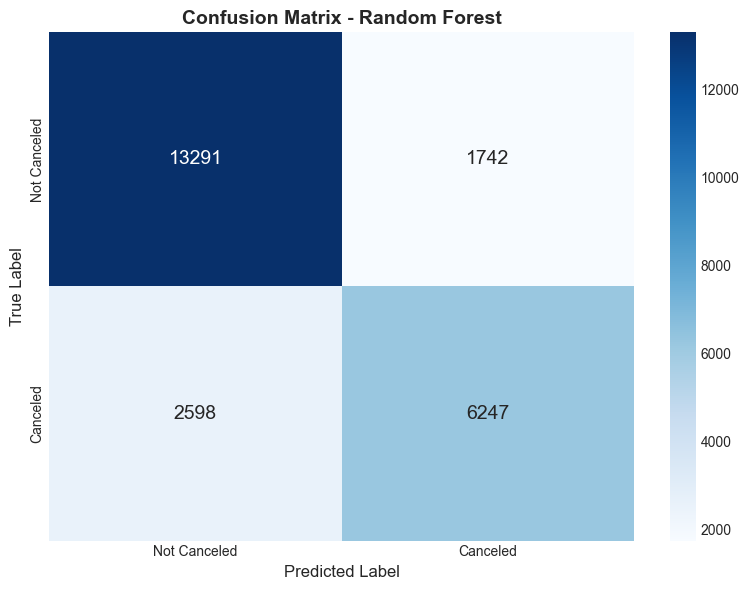

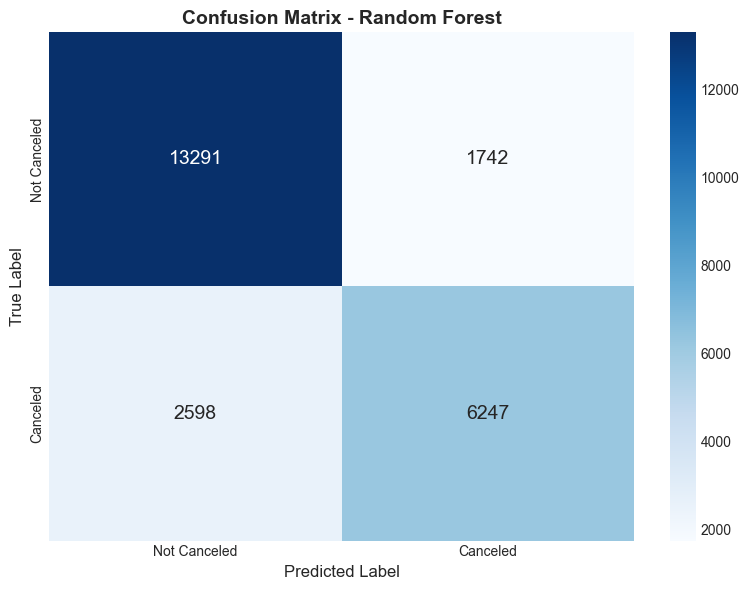

In [14]:
# Confusion Matrix
plot_confusion_matrix(
    y_test, y_pred_rf,
    title='Confusion Matrix - Random Forest',
    save_path=str(FIGURES_DIR / 'cm_random_forest.png'),
    show=True
)

### 6.1 Random Forest Hyperparameter Tuning

In [15]:
# Hyperparameter tuning for Random Forest
# Using RandomizedSearch for faster results (can change to 'grid' for exhaustive search)

# Custom parameter grid (smaller for faster execution)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 0.5]
}

best_rf, best_rf_params, best_rf_score = tune_hyperparameters(
    'rf',
    X_train, y_train,
    param_grid=rf_param_grid,
    search_method='random',
    cv=3,  # Reduced CV for speed
    scoring='f1',
    n_iter=10,
    verbose=True
)

HYPERPARAMETER TUNING: RF
Search method: random
CV folds: 3
Scoring: f1
Parameter grid: {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 5], 'max_features': ['sqrt', 0.5]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits



Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 20}
Best CV f1: 0.8575


In [16]:
# Evaluate tuned Random Forest
y_pred_rf_tuned = best_rf.predict(X_test)
y_proba_rf_tuned = best_rf.predict_proba(X_test)[:, 1]

metrics_rf_tuned = calculate_metrics(y_test, y_pred_rf_tuned, y_proba_rf_tuned, verbose=True)


CLASSIFICATION METRICS
Accuracy:    0.8569
Precision:   0.8275
Recall:      0.7752
F1 Score:    0.8005
Specificity: 0.9049
ROC-AUC:     0.9266
PR-AUC:      0.9029


## 7. XGBoost (if available)

In [17]:
if XGBOOST_AVAILABLE:
    # Train XGBoost
    model_xgb = train_xgboost(
        X_train, y_train,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        verbose=True
    )
    
    # Evaluate
    y_pred_xgb = model_xgb.predict(X_test)
    y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
    
    metrics_xgb = calculate_metrics(y_test, y_pred_xgb, y_proba_xgb, verbose=True)
else:
    print("⚠️ XGBoost not available. Install with: pip install xgboost")
    model_xgb = None
    y_proba_xgb = None
    metrics_xgb = None

TRAINING XGBOOST
Training samples: 120,266
Features: 40
Number of estimators: 100
Max depth: 6
Learning rate: 0.1
Scale pos weight (auto): 1.00


Training accuracy: 0.8549

CLASSIFICATION METRICS
Accuracy:    0.8321
Precision:   0.8013
Recall:      0.7270
F1 Score:    0.7623
Specificity: 0.8940
ROC-AUC:     0.9028
PR-AUC:      0.8740


✅ Saved confusion matrix to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\cm_xgboost.png


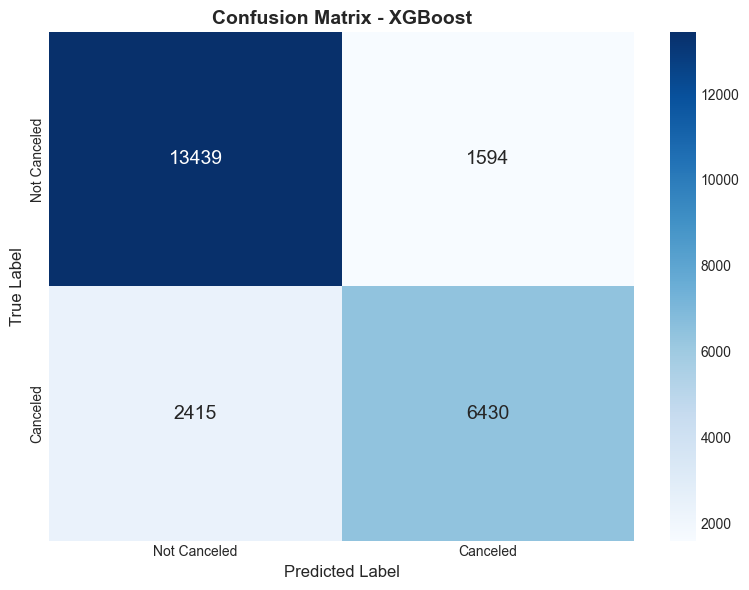

In [18]:
if XGBOOST_AVAILABLE and model_xgb is not None:
    plot_confusion_matrix(
        y_test, y_pred_xgb,
        title='Confusion Matrix - XGBoost',
        save_path=str(FIGURES_DIR / 'cm_xgboost.png'),
        show=True
    )

## 8. LightGBM (if available)

In [19]:
if LIGHTGBM_AVAILABLE:
    # Train LightGBM
    model_lgb = train_lightgbm(
        X_train, y_train,
        n_estimators=100,
        num_leaves=31,
        learning_rate=0.1,
        verbose=True
    )
    
    # Evaluate
    y_pred_lgb = model_lgb.predict(X_test)
    y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]
    
    metrics_lgb = calculate_metrics(y_test, y_pred_lgb, y_proba_lgb, verbose=True)
else:
    print("⚠️ LightGBM not available. Install with: pip install lightgbm")
    model_lgb = None
    y_proba_lgb = None
    metrics_lgb = None

TRAINING LIGHTGBM
Training samples: 120,266
Features: 40
Number of estimators: 100
Max depth: -1
Num leaves: 31
Learning rate: 0.1


Training accuracy: 0.8616

CLASSIFICATION METRICS
Accuracy:    0.8380
Precision:   0.8154
Recall:      0.7273
F1 Score:    0.7689
Specificity: 0.9031
ROC-AUC:     0.9074
PR-AUC:      0.8797


✅ Saved confusion matrix to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\cm_lightgbm.png


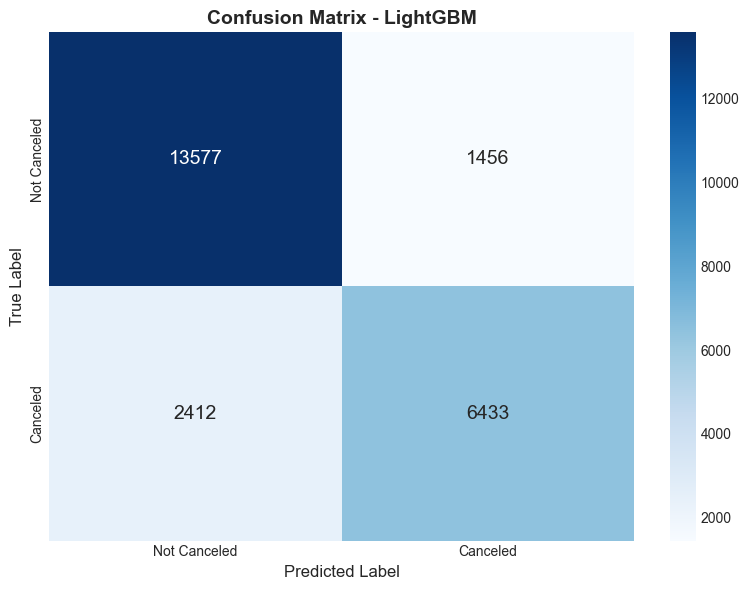

In [20]:
if LIGHTGBM_AVAILABLE and model_lgb is not None:
    plot_confusion_matrix(
        y_test, y_pred_lgb,
        title='Confusion Matrix - LightGBM',
        save_path=str(FIGURES_DIR / 'cm_lightgbm.png'),
        show=True
    )

---

# PART C: MODEL COMPARISON

---

## 9. Compare All Models

In [21]:
# Collect all results
all_results = {
    'Logistic Regression': metrics_lr,
    'Decision Tree': metrics_dt,
    'Random Forest': metrics_rf,
    'Random Forest (Tuned)': metrics_rf_tuned
}

# Add XGBoost if available
if metrics_xgb is not None:
    all_results['XGBoost'] = metrics_xgb

# Add LightGBM if available  
if metrics_lgb is not None:
    all_results['LightGBM'] = metrics_lgb

# Create comparison table
comparison_df = compare_models(
    all_results,
    metrics=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc'],
    verbose=True
)


MODEL COMPARISON
                       accuracy  precision  recall      f1  roc_auc  pr_auc
Random Forest (Tuned)    0.8569     0.8275  0.7752  0.8005   0.9266  0.9029
LightGBM                 0.8380     0.8154  0.7273  0.7689   0.9074  0.8797
XGBoost                  0.8321     0.8013  0.7270  0.7623   0.9028  0.8740
Random Forest            0.8182     0.7820  0.7063  0.7422   0.8963  0.8654
Decision Tree            0.8098     0.7794  0.6786  0.7255   0.8773  0.8283
Logistic Regression      0.7645     0.6777  0.6946  0.6861   0.8391  0.8018

🏆 Best model by F1: Random Forest (Tuned) (0.8005)


In [22]:
# Save comparison table
comparison_df.to_csv(TABLES_DIR / 'model_comparison.csv')
print(f"✅ Saved comparison table to {TABLES_DIR / 'model_comparison.csv'}")

✅ Saved comparison table to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\tables\model_comparison.csv


✅ Saved model comparison plot to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\model_comparison.png


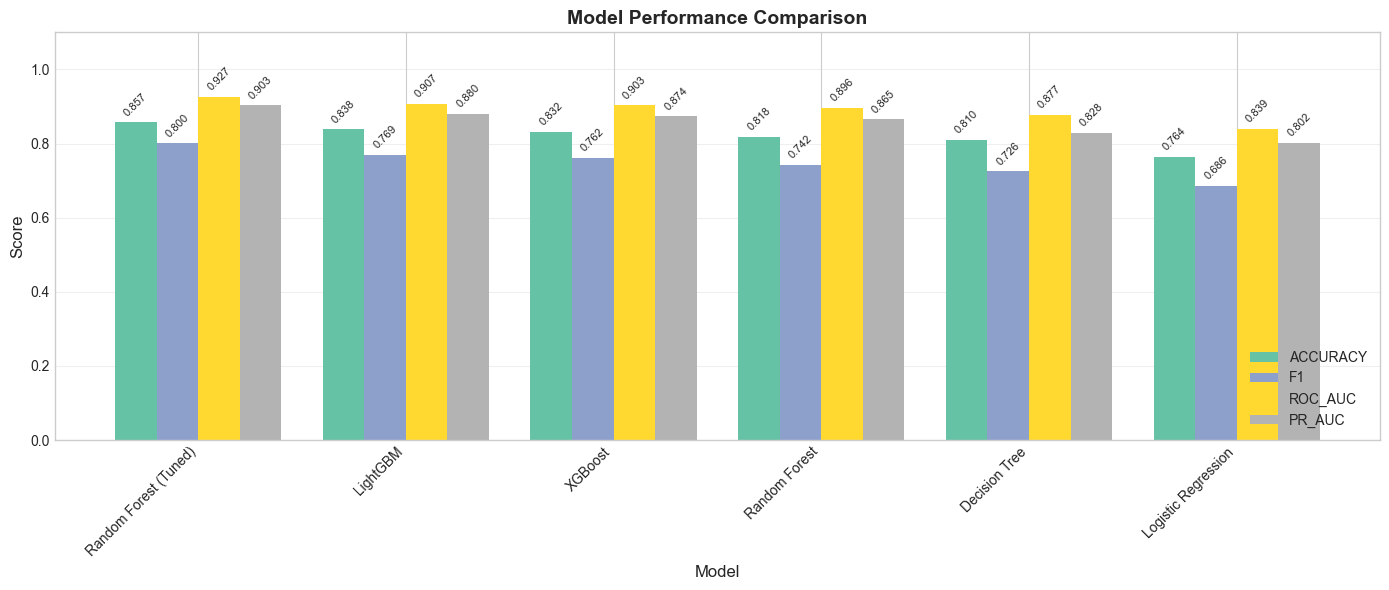

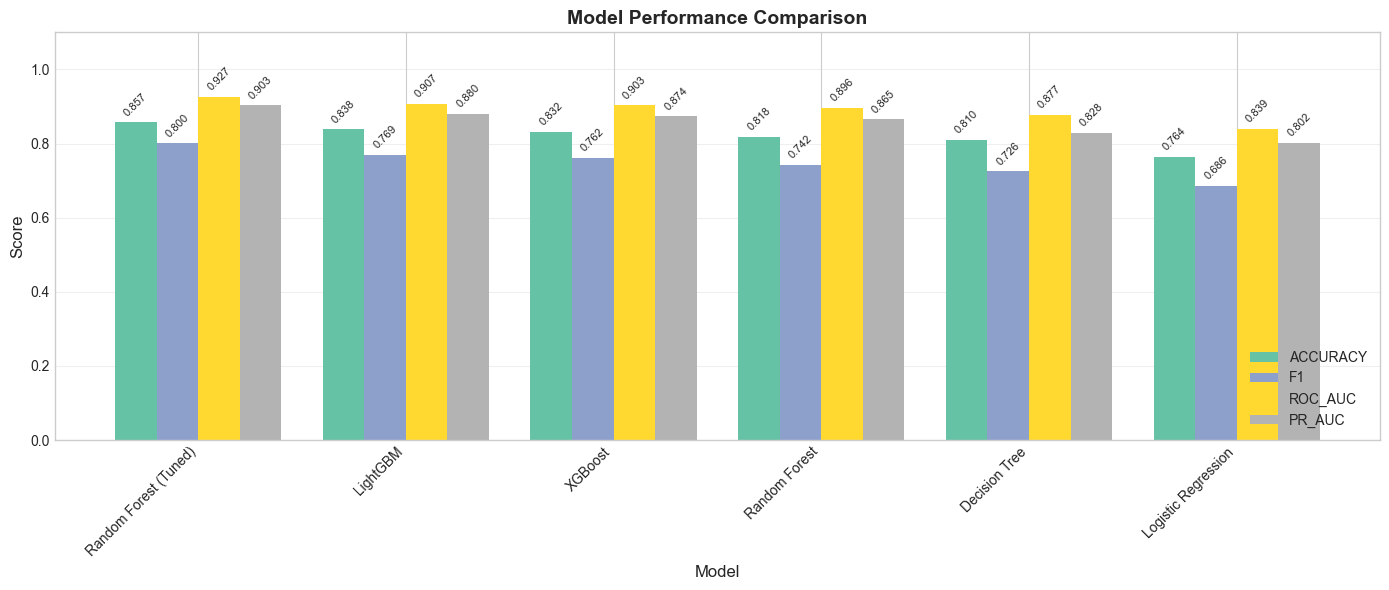

In [23]:
# Plot model comparison
plot_model_comparison(
    comparison_df,
    metrics=['accuracy', 'f1', 'roc_auc', 'pr_auc'],
    title='Model Performance Comparison',
    figsize=(14, 6),
    save_path=str(FIGURES_DIR / 'model_comparison.png'),
    show=True
)

## 10. ROC Curves Comparison

✅ Saved ROC curves comparison to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\roc_curves_comparison.png


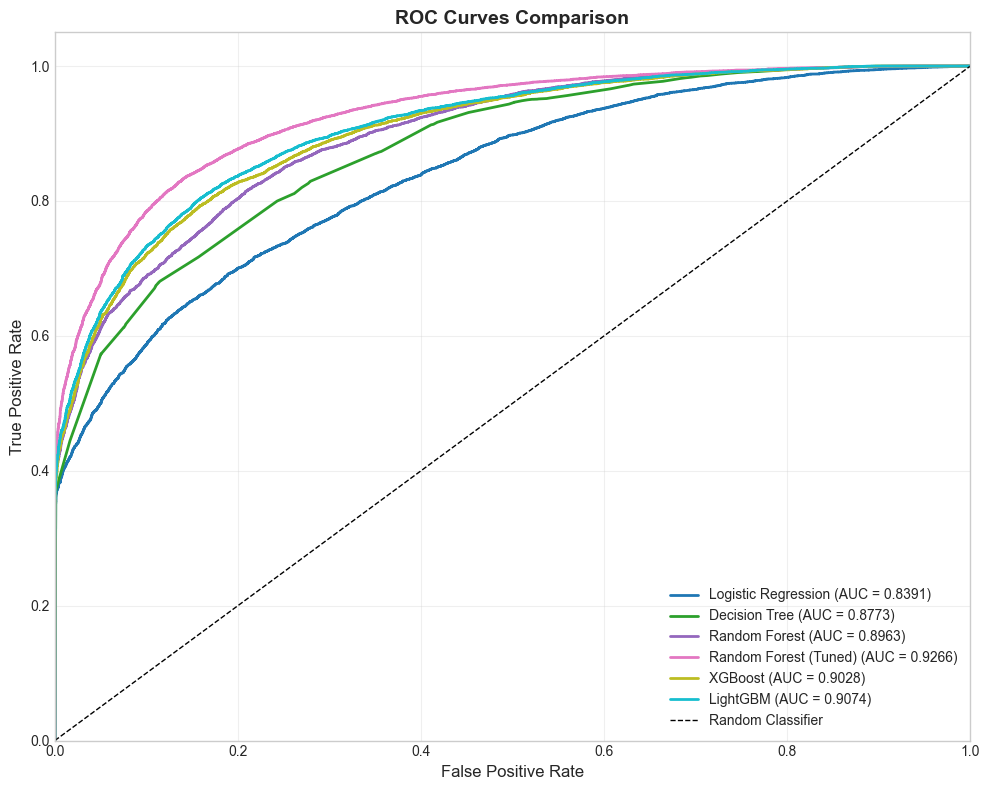

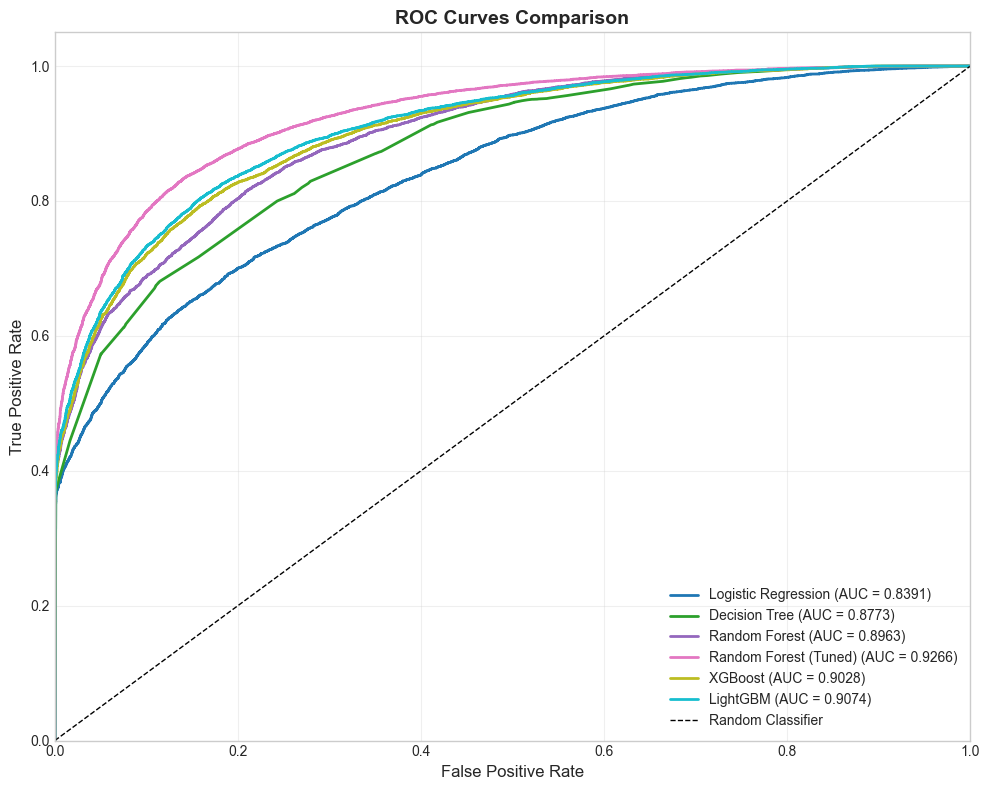

In [24]:
# Collect predictions for ROC curves
predictions_for_roc = {
    'Logistic Regression': y_proba_lr,
    'Decision Tree': y_proba_dt,
    'Random Forest': y_proba_rf,
    'Random Forest (Tuned)': y_proba_rf_tuned
}

if y_proba_xgb is not None:
    predictions_for_roc['XGBoost'] = y_proba_xgb
    
if y_proba_lgb is not None:
    predictions_for_roc['LightGBM'] = y_proba_lgb

# Plot ROC curves
plot_roc_curves_comparison(
    y_test,
    predictions_for_roc,
    figsize=(10, 8),
    save_path=str(FIGURES_DIR / 'roc_curves_comparison.png'),
    show=True
)

## 11. Precision-Recall Curves Comparison

✅ Saved PR curves comparison to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\pr_curves_comparison.png


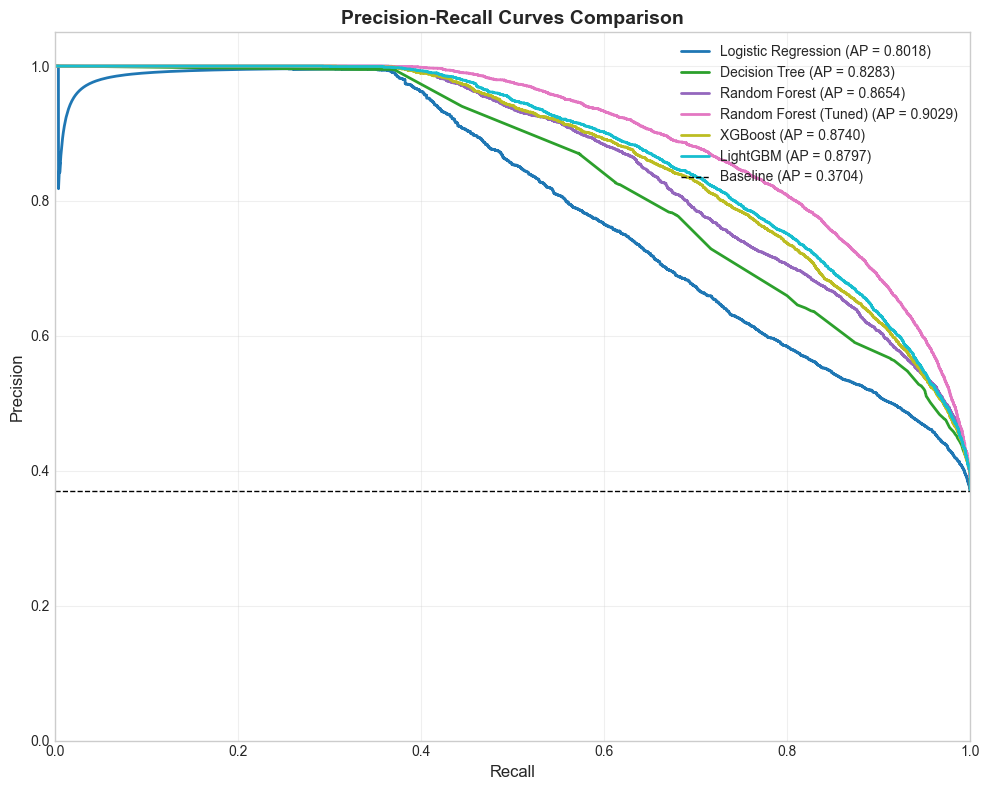

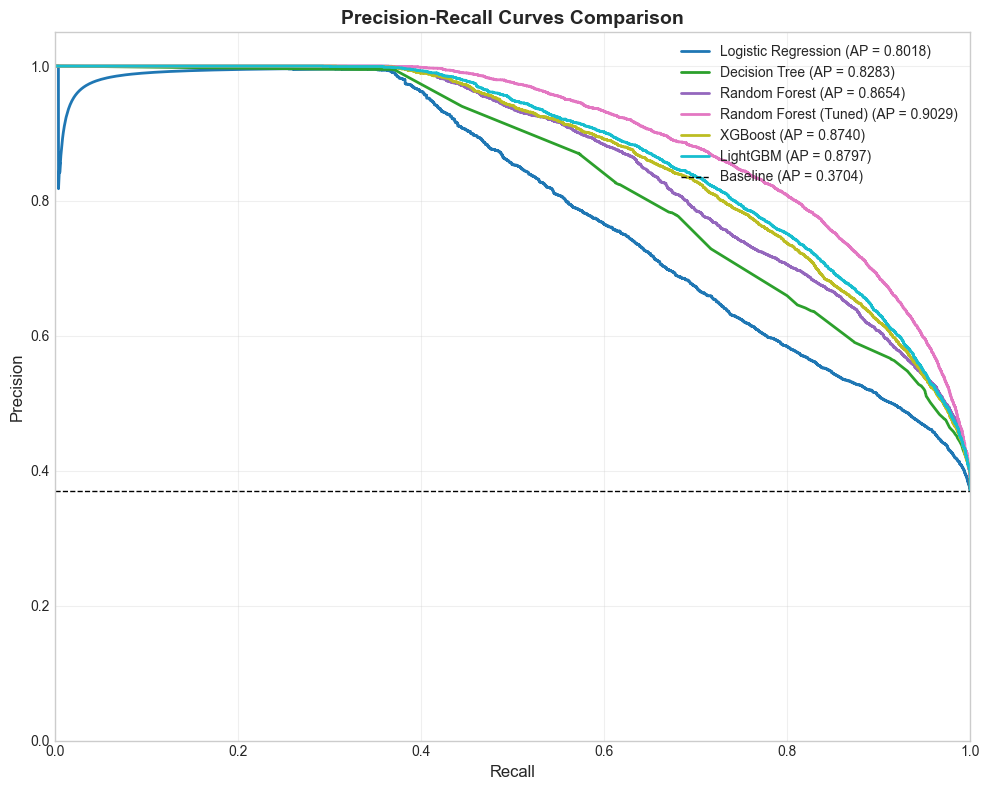

In [25]:
# Plot PR curves
plot_pr_curves_comparison(
    y_test,
    predictions_for_roc,
    figsize=(10, 8),
    save_path=str(FIGURES_DIR / 'pr_curves_comparison.png'),
    show=True
)

---

# PART D: CROSS-VALIDATION

---

## 12. 5-Fold Cross-Validation

In [26]:
# Cross-validation for best model (Random Forest Tuned)
print("🔄 Running 5-fold Cross-Validation on Random Forest (Tuned)...\n")

cv_results_rf = cross_validate_model(
    best_rf,
    X_train, y_train,
    cv=5,
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
    verbose=True
)

🔄 Running 5-fold Cross-Validation on Random Forest (Tuned)...

CROSS-VALIDATION
Model: RandomForestClassifier
Folds: 5
Metrics: ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']



ACCURACY:
  Mean: 0.8757 (+/- 0.0032)
  Per fold: ['0.8787', '0.8741', '0.8761', '0.8751', '0.8747']



F1:
  Mean: 0.8722 (+/- 0.0035)
  Per fold: ['0.8755', '0.8704', '0.8725', '0.8714', '0.8714']



PRECISION:
  Mean: 0.8975 (+/- 0.0032)
  Per fold: ['0.8992', '0.8967', '0.8988', '0.8979', '0.8947']



RECALL:
  Mean: 0.8484 (+/- 0.0052)
  Per fold: ['0.8530', '0.8456', '0.8477', '0.8464', '0.8493']



ROC_AUC:
  Mean: 0.9487 (+/- 0.0018)
  Per fold: ['0.9486', '0.9470', '0.9490', '0.9499', '0.9488']


In [27]:
# Cross-validation for Logistic Regression (baseline comparison)
print("🔄 Running 5-fold Cross-Validation on Logistic Regression...\n")

cv_results_lr = cross_validate_model(
    model_lr,
    X_train, y_train,
    cv=5,
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
    verbose=True
)

🔄 Running 5-fold Cross-Validation on Logistic Regression...

CROSS-VALIDATION
Model: LogisticRegression
Folds: 5
Metrics: ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']



ACCURACY:
  Mean: 0.7852 (+/- 0.0106)
  Per fold: ['0.7798', '0.7940', '0.7811', '0.7885', '0.7826']



F1:
  Mean: 0.7834 (+/- 0.0093)
  Per fold: ['0.7802', '0.7903', '0.7808', '0.7876', '0.7782']



PRECISION:
  Mean: 0.7901 (+/- 0.0187)
  Per fold: ['0.7788', '0.8048', '0.7817', '0.7910', '0.7945']



RECALL:
  Mean: 0.7769 (+/- 0.0152)
  Per fold: ['0.7816', '0.7763', '0.7800', '0.7842', '0.7626']



ROC_AUC:
  Mean: 0.8747 (+/- 0.0111)
  Per fold: ['0.8711', '0.8812', '0.8680', '0.8815', '0.8717']


In [28]:
# Create CV comparison table
cv_comparison = pd.DataFrame({
    'Metric': ['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
    'Logistic (Mean)': [cv_results_lr[m].mean() for m in ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']],
    'Logistic (Std)': [cv_results_lr[m].std() for m in ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']],
    'RF Tuned (Mean)': [cv_results_rf[m].mean() for m in ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']],
    'RF Tuned (Std)': [cv_results_rf[m].std() for m in ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']],
})

print("\n📊 Cross-Validation Comparison:")
print(cv_comparison.round(4).to_string(index=False))

# Save
cv_comparison.to_csv(TABLES_DIR / 'cv_comparison.csv', index=False)
print(f"\n✅ Saved CV comparison to {TABLES_DIR / 'cv_comparison.csv'}")


📊 Cross-Validation Comparison:
   Metric  Logistic (Mean)  Logistic (Std)  RF Tuned (Mean)  RF Tuned (Std)
 accuracy           0.7852          0.0053           0.8757          0.0016
       f1           0.7834          0.0047           0.8722          0.0018
precision           0.7901          0.0093           0.8975          0.0016
   recall           0.7769          0.0076           0.8484          0.0026
  roc_auc           0.8747          0.0056           0.9487          0.0009

✅ Saved CV comparison to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\tables\cv_comparison.csv


---

# PART E: FEATURE IMPORTANCE ANALYSIS

---

## 13. Feature Importance

In [29]:
# Get feature importance from Random Forest
importance_rf = get_feature_importance(
    best_rf,
    feature_names,
    verbose=True
)


📊 TOP 10 IMPORTANT FEATURES:
--------------------------------------------------
 1. deposit_required                20.34%
 2. lead_time                       11.33%
 3. agent                           10.90%
 4. has_special_requests             7.84%
 5. room_type_changed                7.29%
 6. adr                              5.53%
 7. has_booking_changes              3.36%
 8. total_revenue                    3.31%
 9. revenue_per_guest                3.14%
10. arrival_date_week_number         3.06%


✅ Saved feature importance plot to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\feature_importance_rf.png


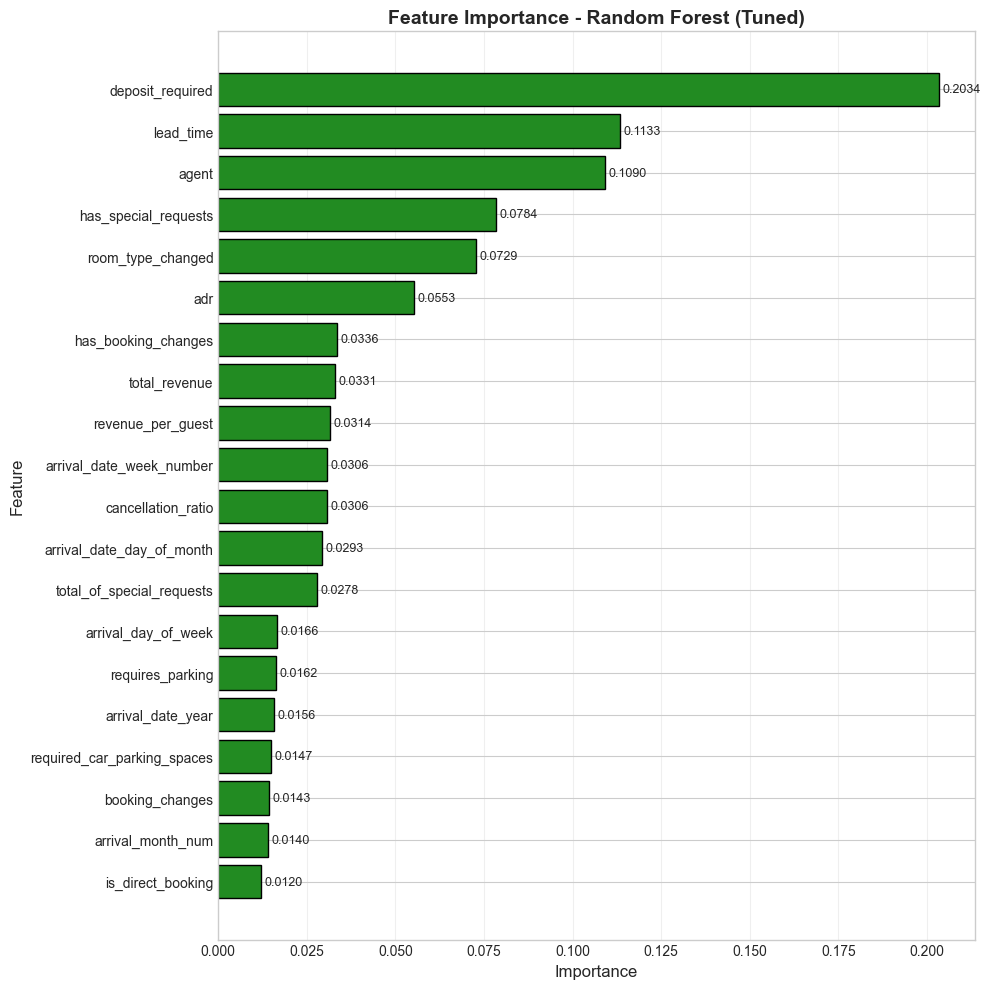

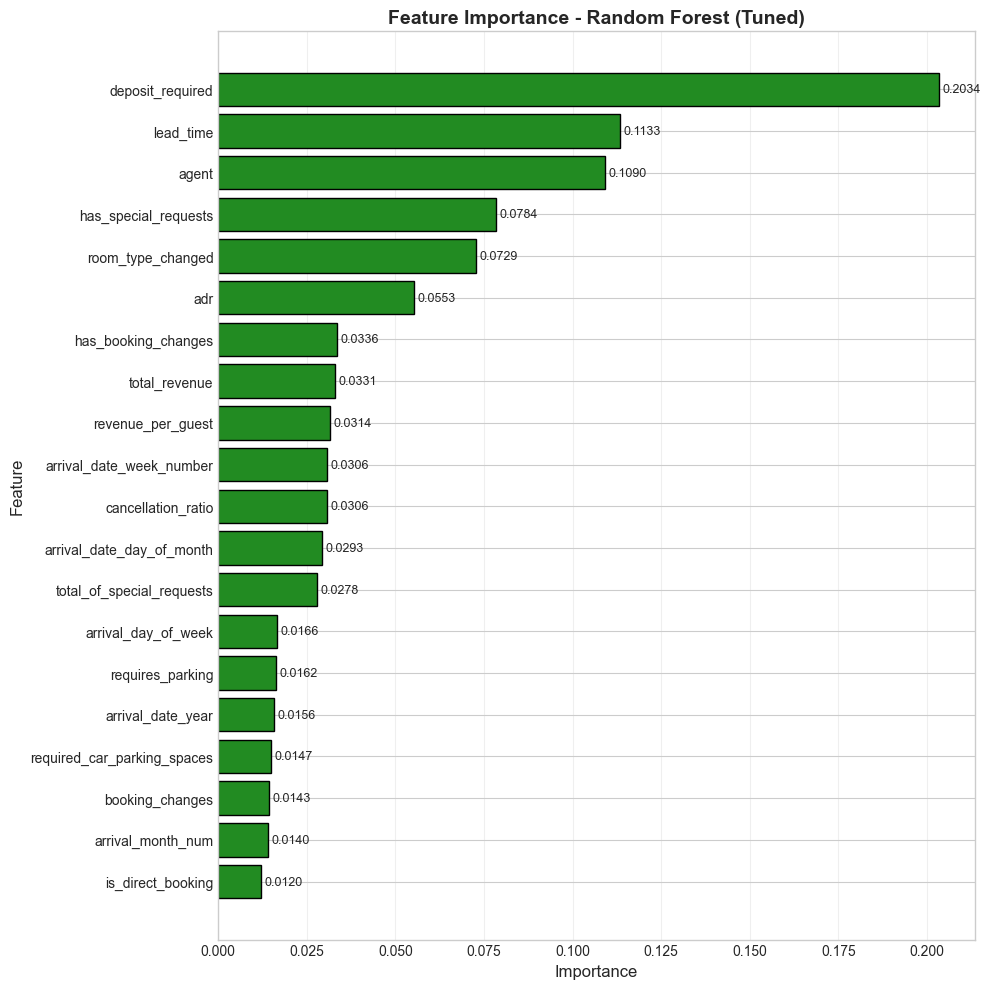

In [30]:
# Plot feature importance
plot_feature_importance(
    importance_rf,
    top_n=20,
    title='Feature Importance - Random Forest (Tuned)',
    figsize=(10, 10),
    color='forestgreen',
    save_path=str(FIGURES_DIR / 'feature_importance_rf.png'),
    show=True
)

In [31]:
# Feature importance from Logistic Regression (coefficient magnitude)
importance_lr = get_feature_importance(
    model_lr,
    feature_names,
    verbose=True
)


📊 TOP 10 IMPORTANT FEATURES:
--------------------------------------------------
 1. deposit_required                13.94%
 2. room_type_changed               10.06%
 3. required_car_parking_spaces      5.98%
 4. requires_parking                 5.95%
 5. is_direct_booking                5.84%
 6. cancellation_ratio               5.57%
 7. previous_cancellations           5.49%
 8. has_canceled_before              4.79%
 9. has_booking_changes              4.51%
10. has_special_requests             4.40%


✅ Saved feature importance plot to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\feature_importance_lr.png


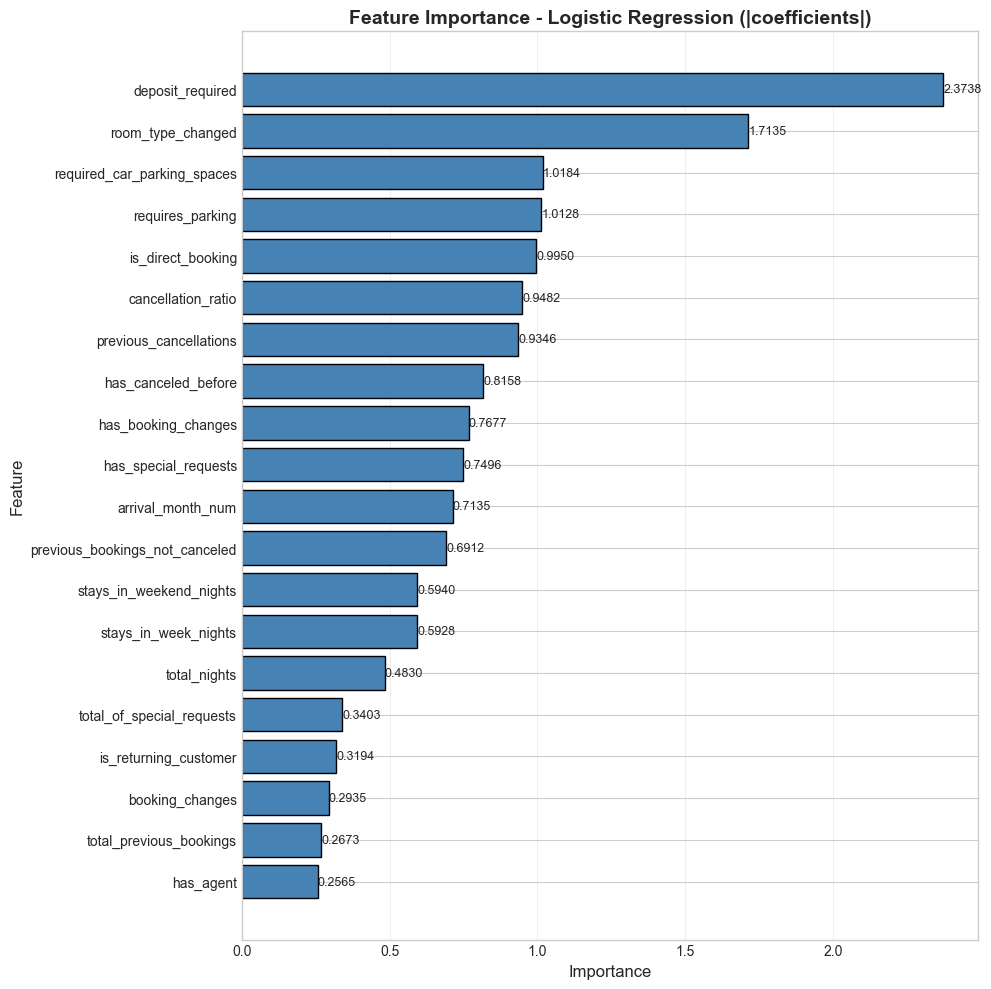

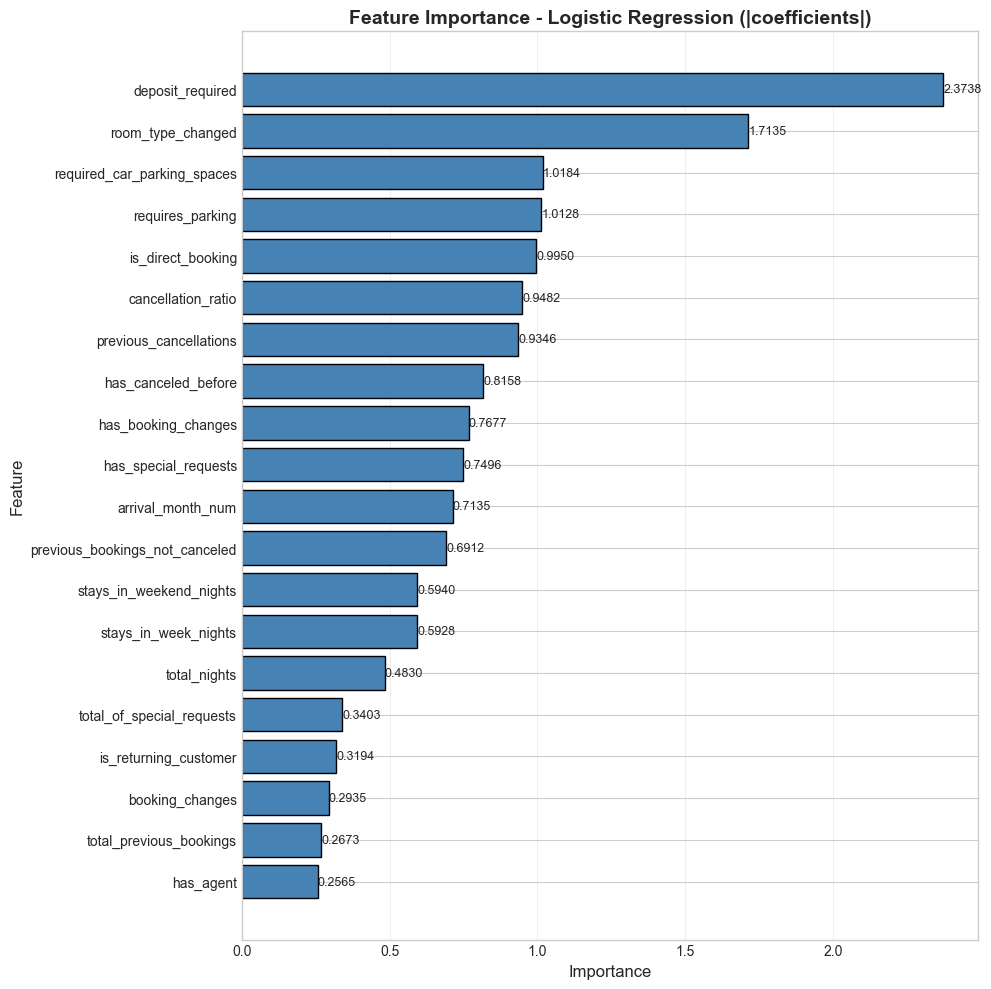

In [32]:
# Plot LR feature importance
plot_feature_importance(
    importance_lr,
    top_n=20,
    title='Feature Importance - Logistic Regression (|coefficients|)',
    figsize=(10, 10),
    color='steelblue',
    save_path=str(FIGURES_DIR / 'feature_importance_lr.png'),
    show=True
)

In [33]:
# Save feature importance to CSV
importance_rf.to_csv(TABLES_DIR / 'feature_importance_rf.csv', index=False)
importance_lr.to_csv(TABLES_DIR / 'feature_importance_lr.csv', index=False)
print(f"✅ Saved feature importance tables to {TABLES_DIR}")

✅ Saved feature importance tables to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\tables


## 14. Threshold Analysis

In [34]:
# Find optimal threshold for best model
optimal_threshold, optimal_f1 = find_optimal_threshold(
    y_test, y_proba_rf_tuned,
    metric='f1',
    verbose=True
)


📊 Optimal threshold for F1:
   Threshold: 0.45
   Score: 0.8048


✅ Saved threshold analysis to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\threshold_analysis.png


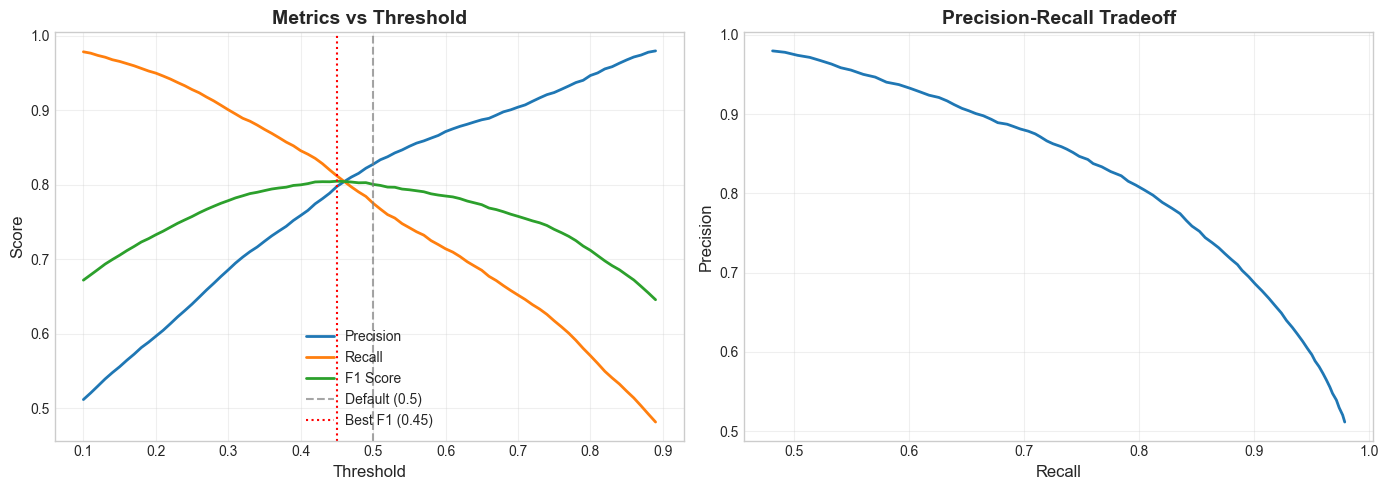

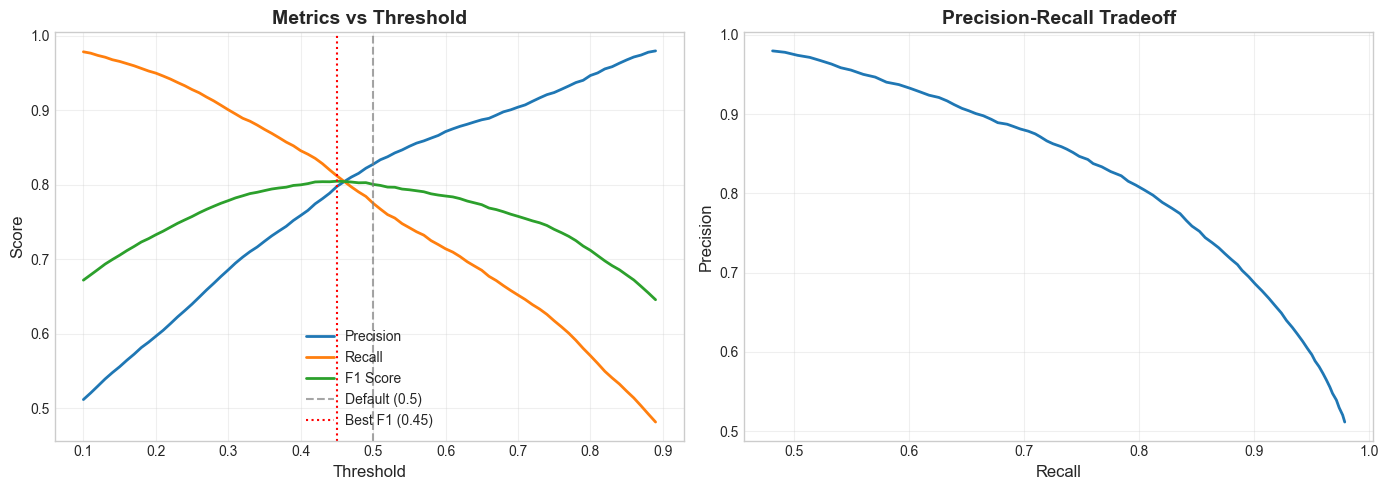

In [35]:
# Plot threshold analysis
plot_threshold_analysis(
    y_test, y_proba_rf_tuned,
    figsize=(14, 5),
    save_path=str(FIGURES_DIR / 'threshold_analysis.png'),
    show=True
)

In [36]:
# Compare default vs optimal threshold
print("\n📊 Comparison: Default (0.5) vs Optimal Threshold")
print("=" * 60)

# Default threshold
y_pred_default = (y_proba_rf_tuned >= 0.5).astype(int)
metrics_default = calculate_metrics(y_test, y_pred_default, y_proba_rf_tuned, verbose=False)

# Optimal threshold
y_pred_optimal = (y_proba_rf_tuned >= optimal_threshold).astype(int)
metrics_optimal = calculate_metrics(y_test, y_pred_optimal, y_proba_rf_tuned, verbose=False)

print(f"\nDefault Threshold (0.5):")
print(f"   F1: {metrics_default['f1']:.4f}, Precision: {metrics_default['precision']:.4f}, Recall: {metrics_default['recall']:.4f}")

print(f"\nOptimal Threshold ({optimal_threshold:.2f}):")
print(f"   F1: {metrics_optimal['f1']:.4f}, Precision: {metrics_optimal['precision']:.4f}, Recall: {metrics_optimal['recall']:.4f}")

print(f"\nImprovement in F1: {(metrics_optimal['f1'] - metrics_default['f1'])*100:.2f}%")


📊 Comparison: Default (0.5) vs Optimal Threshold

Default Threshold (0.5):
   F1: 0.8005, Precision: 0.8275, Recall: 0.7752

Optimal Threshold (0.45):
   F1: 0.8048, Precision: 0.7977, Recall: 0.8120

Improvement in F1: 0.43%


---

# PART F: SAVE MODELS

---

## 15. Save Trained Models

In [37]:
# Save all models
save_model(model_lr, MODELS_DIR / 'logistic_regression.joblib', verbose=True)
save_model(model_dt, MODELS_DIR / 'decision_tree.joblib', verbose=True)
save_model(model_rf, MODELS_DIR / 'random_forest.joblib', verbose=True)
save_model(best_rf, MODELS_DIR / 'random_forest_tuned.joblib', verbose=True)

if model_xgb is not None:
    save_model(model_xgb, MODELS_DIR / 'xgboost.joblib', verbose=True)
    
if model_lgb is not None:
    save_model(model_lgb, MODELS_DIR / 'lightgbm.joblib', verbose=True)

✅ Model saved to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\models\logistic_regression.joblib
✅ Model saved to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\models\decision_tree.joblib


✅ Model saved to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\models\random_forest.joblib
✅ Model saved to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\models\random_forest_tuned.joblib
✅ Model saved to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\models\xgboost.joblib
✅ Model saved to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\models\lightgbm.joblib


---

## 16. Summary & Key Findings

In [38]:
print("\n" + "=" * 80)
print("📝 SUMMARY OF CLASSIFICATION MODELS")
print("=" * 80)

print("\n" + "-" * 40)
print("BASELINE MODELS")
print("-" * 40)
print(f"1. Logistic Regression:")
print(f"   - F1 Score: {metrics_lr['f1']:.4f}")
print(f"   - ROC-AUC: {metrics_lr.get('roc_auc', 'N/A'):.4f}")
print(f"   - PR-AUC: {metrics_lr.get('pr_auc', 'N/A'):.4f}")

print(f"\n2. Decision Tree:")
print(f"   - F1 Score: {metrics_dt['f1']:.4f}")
print(f"   - ROC-AUC: {metrics_dt.get('roc_auc', 'N/A'):.4f}")
print(f"   - PR-AUC: {metrics_dt.get('pr_auc', 'N/A'):.4f}")

print("\n" + "-" * 40)
print("IMPROVED MODELS")
print("-" * 40)
print(f"3. Random Forest (Tuned):")
print(f"   - F1 Score: {metrics_rf_tuned['f1']:.4f}")
print(f"   - ROC-AUC: {metrics_rf_tuned.get('roc_auc', 'N/A'):.4f}")
print(f"   - PR-AUC: {metrics_rf_tuned.get('pr_auc', 'N/A'):.4f}")
print(f"   - Best params: {best_rf_params}")

if metrics_xgb is not None:
    print(f"\n4. XGBoost:")
    print(f"   - F1 Score: {metrics_xgb['f1']:.4f}")
    print(f"   - ROC-AUC: {metrics_xgb.get('roc_auc', 'N/A'):.4f}")

if metrics_lgb is not None:
    print(f"\n5. LightGBM:")
    print(f"   - F1 Score: {metrics_lgb['f1']:.4f}")
    print(f"   - ROC-AUC: {metrics_lgb.get('roc_auc', 'N/A'):.4f}")

print("\n" + "-" * 40)
print("KEY FINDINGS")
print("-" * 40)

# Find best model
best_model_name = comparison_df['f1'].idxmax()
best_f1 = comparison_df.loc[best_model_name, 'f1']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {best_f1:.4f}")

print(f"\n📊 Top 5 Important Features (from RF):")
for i, row in importance_rf.head(5).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance_pct']:.2f}%")

print(f"\n🎯 Optimal Threshold: {optimal_threshold:.2f} (vs default 0.5)")
print(f"   Improvement in F1: {(metrics_optimal['f1'] - metrics_default['f1'])*100:.2f}%")

print("\n" + "-" * 40)
print("SAVED OUTPUTS")
print("-" * 40)
print(f"📁 Models: {MODELS_DIR}")
print(f"📁 Figures: {FIGURES_DIR}")
print(f"📁 Tables: {TABLES_DIR}")

print("\n" + "=" * 80)
print("✅ CLASSIFICATION MODELING COMPLETE!")
print("=" * 80)


📝 SUMMARY OF CLASSIFICATION MODELS

----------------------------------------
BASELINE MODELS
----------------------------------------
1. Logistic Regression:
   - F1 Score: 0.6861
   - ROC-AUC: 0.8391
   - PR-AUC: 0.8018

2. Decision Tree:
   - F1 Score: 0.7255
   - ROC-AUC: 0.8773
   - PR-AUC: 0.8283

----------------------------------------
IMPROVED MODELS
----------------------------------------
3. Random Forest (Tuned):
   - F1 Score: 0.8005
   - ROC-AUC: 0.9266
   - PR-AUC: 0.9029
   - Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 20}

4. XGBoost:
   - F1 Score: 0.7623
   - ROC-AUC: 0.9028

5. LightGBM:
   - F1 Score: 0.7689
   - ROC-AUC: 0.9074

----------------------------------------
KEY FINDINGS
----------------------------------------

🏆 Best Model: Random Forest (Tuned)
   F1 Score: 0.8005

📊 Top 5 Important Features (from RF):
   1. deposit_required: 20.34%
   2. lead_time: 11.33%
   3. agent: 10.90%
   